In [5]:
import numpy as np                                                           
import pandas as pd
import requests
import json
import random
import os
from ggplot import *

def warn_for_large_dl(opts_dict, threshold=100000, sample_rate_hz=60):
    total_time = opts_dict["EndTime"] - opts_dict["StartTime"]
    to_ns = {
        'years': 31556952000000430,
        'weeks': 604799999999983,
        'days' : 86400000000000,
        'hours': 3600000000000,
        'minutes': 60000000000,
        's': 1000000000,
        'seconds': 1000000000,
        'ms': 1000000,
        'milliseconds': 1000000,
        '': 1000000,
        'us': 1000,
        'microseconds': 1000,
        'ns': 1,
        'nanoseconds': 1
    }

    total_time_ns = total_time * to_ns[opts_dict["UnitofTime"]]

    query_type = opts_dict["QueryType"]
    if query_type == 'windows':
        ns_per_point = int(opts_dict['WindowText']) * int(to_ns[opts_dict['WindowUnit']])
        total_rows = total_time_ns // ns_per_point

    total_obs_at_sample_rate = total_time_ns // (1/sample_rate_hz * to_ns['s'])

    if query_type == 'aligned':
        total_rows = total_time_ns // (2 ** opts_dict.get("PointWidth", 0))
        total_rows = min(total_rows, total_obs_at_sample_rate)
    elif query_type == 'raw':
        total_rows = total_obs_at_sample_rate

    print('Assuming {}hz sampling, you are downloading approximately {} rows.'.format(sample_rate_hz, int(total_rows)))
    if (total_rows > threshold):
        print('This exceeds your threshold of {}'.format(threshold))
        print('''
    Either increase your threshold or choose closer start and end times.
    If you are using QueryType: 'raw' then you must choose a closer start and end time.
    If you are using QueryType: 'aligned' you may also increase PointWidth to sample less frequently.
    If you are using QueryType: 'windows' you may also increase WindowText to sample less frequently.
        ''')
        return True
    return False
    
def download_pmu_data(opts_dict, domain=None, filename=None):
    if domain is None:
        raise ValueError("You must supply a domain to download_pmu_data (e.g. https://viz.predictivegrid.com)")
    if filename is None:
        filename = 'pmu_data.csv'
    url = domain + '/csv'
    payload = "json=" + json.dumps(opts_dict)
    print("Starting download...")
    r = requests.post(url, data=payload, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    print("Download finished")
    return filename

def make_df(csv_filename=None, max_size=100):
    if csv_filename is None:
        csv_filename = 'pmu_data.csv'
    file_size_mb = os.path.getsize(csv_filename) / 1024 / 1024
    if file_size_mb > max_size:
        print('The file is {:.2f}mb, which is larger than your threshold of {}mb. You may want to process it manually instead.'.format(file_size_mb, max_size))
        print('It is located at: {}/{}'.format(os.getcwd(), csv_filename))
        df = pd.read_csv(csv_filename, chunksize=10000)
        print('Returning a {} instead'.format(type(df)))
    else:
        df = pd.read_csv(csv_filename)
        print("Created dataframe of shape:", df.shape)
    return df

# The following dict's values determine the data downloaded. Some fields behave differently depending on QueryType.
#   "StartTime" : Int    - Represents the start time expressed in Epoch. Units determined by "UnitofTime"
#   "EndTime"   : Int    - Represents the end time expressed in Epoch. Units determined by "UnitofTime"
#   "UnitofTime": String - enum represents the unit of time applied to the "StartTime" and "EndTime" fields. One of "s", "ms", "us", "ns", "". "" is an alias for "ms".
#   "UUIDS"     : List   - list of UUID strings for the streams being downloaded
#   "Labels"    : List   - list of label strings to use for each stream in the outputted data
#   "QueryType" : String - enum with one of three values (windows, aligned, raw)
#   "WindowText": String - Valid only for QueryType "windows." Together with WindowUnit represents the amount of time per data point
#   "WindowUnit": String - Valid only for QueryType "windows." enum representing the unit of time to use for WindowText. One of "years","weeks","days","hours","minutes","seconds","milliseconds","microseconds","nanoseconds"
#   "PointWidth": Int    - The point width exponent for AlignedWindows queries, and the maximum depth for Windows queries. It is ignored for QueryType: "raw"
#   "_token"    : String - The token string issued by the server granting a user access for the current session.
                                                            
                                                            
opts_dict = {
    "StartTime": 1507892842460,
    "EndTime": 1512176702793,
    "UUIDS": [
        "4d6e251a-48e1-3bc0-907d-7d5440c34bb9",
        "9dc5b5cd-8cb1-3dd3-b582-5ed6bf3f0083",
        "7befb598-a0be-3e5f-a062-84f9fda33a13",
        "39d955bf-4b68-36c1-801d-5a54c8b0d953",
        "3c9a6de2-4b5e-3707-b599-449c395b3d2b"
    ],
    "Labels": [
        "ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand",
        "ciee/ devices/ meter/ 0xd8d5b9000000a110/ price",
        "ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received",
        "ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered",
        "ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier"
    ],
    "QueryType": "aligned",
    "WindowText": "4398046511104",
    "WindowUnit": "nanoseconds",
    "UnitofTime": "ms",
    "PointWidth": 41,
    "_token": "EQ/VyUIn1j3SdK8QLsDM8Zcq6HuNKNupauO5gCLtSaKrDlpvFEOWwwANwYyNmqF/ezI2doI3y23afne7kBN4ooMcn5NSxwxTxc/ATL9HlTN1D1/V1a6IrmSdn7rlU7E0YN8D5nmCkQ5FJwu4N0JFhz/hx1qXr/e2LuxzubfFDXjAwi9jmZJZq3pa3rVzXxH4/QcER26B9NBWeUhqC/gdoA=="
}

domain = "https://plot.xbos.io"
                                                            
too_big = warn_for_large_dl(opts_dict, threshold=20000, sample_rate_hz=60)
if (not too_big):
    csv_filename = download_pmu_data(opts_dict, domain=domain)
    df = make_df(csv_filename, max_size=1)
    print("Done")
else:
    print("Aborted download.")

                                                            

Assuming 60hz sampling, you are downloading approximately 1948 rows.
Starting download...
Download finished
Created dataframe of shape: (0, 1)
Done


In [24]:
df = make_df(csv_filename, max_size=1)
print(type(df).__name__)

Created dataframe of shape: (1856, 22)
DataFrame


In [46]:
list(df.columns.values)

['Timestamp (ns)',
 'Human-Readable Time (UTC)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Max)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Count)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Max)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Count)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Max)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Count)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ s

In [48]:
df[0:]

,Timestamp (ns),Human-Readable Time (UTC),ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Min),ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Mean),ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Max),ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Count),ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Min),ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Mean),ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Max),ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Count),...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Max),ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Count),ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Min),ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Mean),ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Max),ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Count),ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier (Min),ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier (Mean),ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier (Max),ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier (Count)
0,1507892236564561920,2017-10-13 10:57:16.564561920,1760.0,1964.282238,3360.0,411.0,0.21197,0.211970,0.21197,411,...,0.25,411.0,774.313,774.327959,774.342,411,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
1,1507894435587817472,2017-10-13 11:33:55.587817472,1760.0,1870.851582,3320.0,411.0,0.21197,0.211970,0.21197,411,...,0.25,411.0,774.342,774.357876,774.370,411,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
2,1507896634611073024,2017-10-13 12:10:34.611073024,1760.0,2337.365854,4000.0,410.0,0.21197,0.211970,0.21197,410,...,0.25,410.0,774.370,774.387449,774.406,410,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
3,1507898833634328576,2017-10-13 12:47:13.634328576,2480.0,2649.359606,4080.0,406.0,0.21197,0.211970,0.21197,406,...,0.25,406.0,774.406,774.425872,774.445,406,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
4,1507901032657584128,2017-10-13 13:23:52.657584128,1840.0,2353.316953,3840.0,407.0,0.21197,0.211970,0.21197,407,...,0.25,407.0,774.445,774.466926,774.486,407,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
5,1507903231680839680,2017-10-13 14:00:31.680839680,1800.0,1921.081081,3320.0,407.0,0.21197,0.211970,0.21197,407,...,0.25,407.0,774.486,774.500027,774.515,407,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
6,1507905430704095232,2017-10-13 14:37:10.704095232,1760.0,2245.951220,4160.0,410.0,0.21197,0.211970,0.21197,410,...,0.25,410.0,774.515,774.530646,774.548,410,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
7,1507907629727350784,2017-10-13 15:13:49.727350784,1760.0,1911.637280,3320.0,397.0,0.21197,0.226925,0.23933,397,...,0.25,397.0,774.548,774.564914,774.581,397,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...,ciee/ devices/ meter/ 0xd8d5b9000000a110/ tier...
8,150790982875

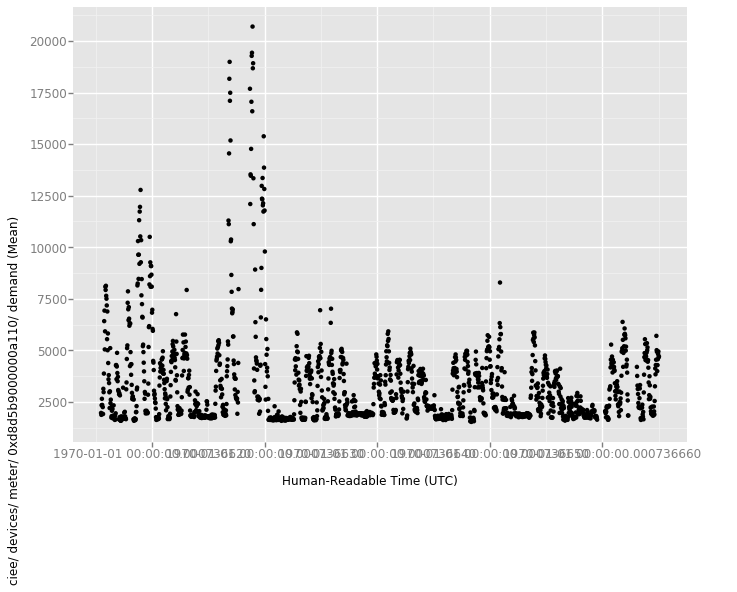

<ggplot: (280048858)>

In [44]:
df['Human-Readable Time (UTC)'] = df['Human-Readable Time (UTC)'].apply(pd.to_datetime)

ggplot(df, aes(x='Human-Readable Time (UTC)',\
                         y= 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Mean)')) + geom_point()

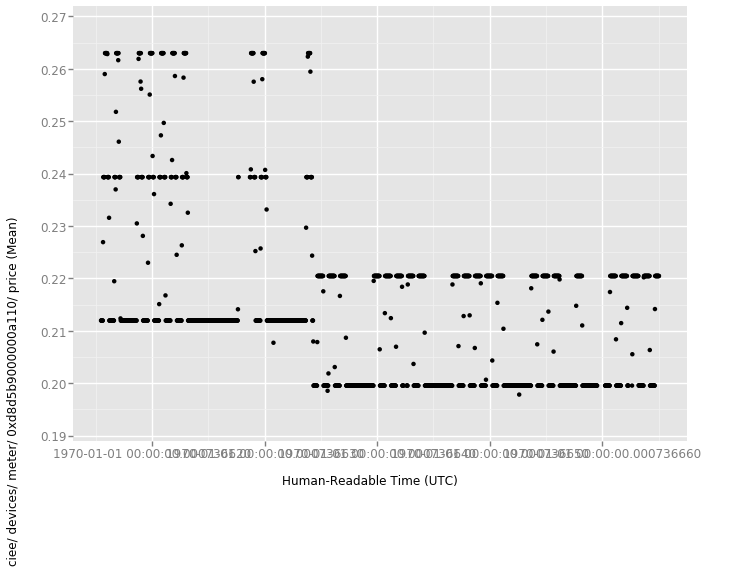

<ggplot: (279329726)>

In [45]:
ggplot(df, aes(x='Human-Readable Time (UTC)',\
                         y= 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Mean)')) + geom_point()


In [32]:
import GPy
from sklearn.preprocessing import normalize

kernel = GPy.kern.PeriodicExponential(1)

X = df['Timestamp (ns)'].values.reshape((-1,1))
Y = df['ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Mean)'].values.reshape((-1,1))

X=np.nan_to_num(X)
Y= np.nan_to_num(Y)

inds = random.sample(range(1, X.shape[0]),800)

X_inds= X[inds]
Y_inds = Y[inds]

X_samp = (X[inds] - X[inds].mean()) /(X[inds].std())
Y_samp = (Y[inds] - Y[inds].mean()) /(Y[inds].std())

In [33]:
m = GPy.models.GPRegression(X_samp,Y_samp,kernel)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0002   1.146379e+03   4.216575e+04 
    02s23  0031   1.026041e+03   2.171990e-01 
    04s26  0059   1.025937e+03   9.998882e-02 
    05s04  0070   1.025937e+03   3.330204e-05 
Runtime:     05s04
Optimization status: Converged



In [31]:
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
periodic_exponential.variance,2.8021733559,+ve,
periodic_exponential.lengthscale,0.0386065057246,+ve,
periodic_exponential.period,3.75759167876,+ve,
Gaussian_noise.variance,0.732439244745,+ve,


 /Users/lucas.spangher/Applications/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 /Users/lucas.spangher/Applications/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


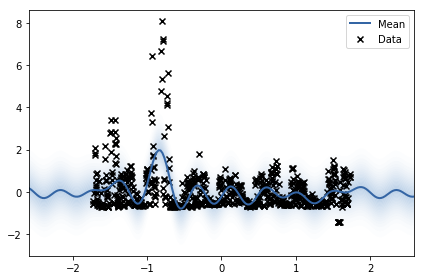

In [212]:
fig = m.plot(plot_density=True)
GPy.plotting.show(fig)

In [ ]:
GPy.kern.

In [192]:
GPy.kern.BasisFuncKernel?